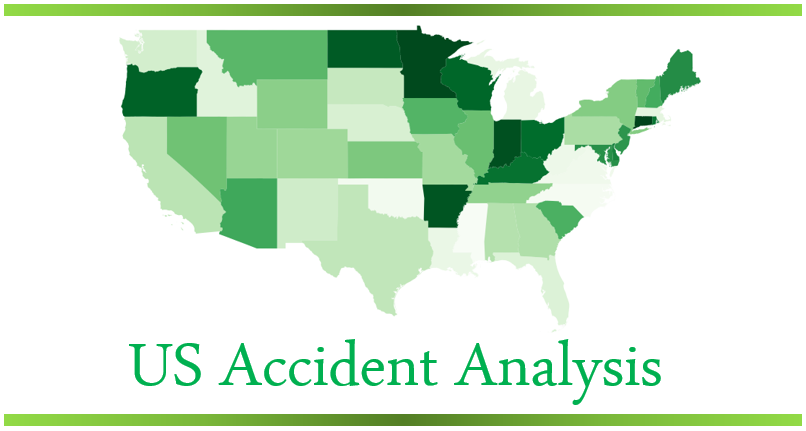

<p style="font-size:20px; font-style:italic;">
This is a countrywide car accident dataset, which covers <span style="color:green;">49 states</span> of the USA. The accident data are collected from <span style="color:green;">February 2016 to December 2020</span>, using multiple APIs that provide streaming traffic incident (or event) data. These APIs broadcast traffic data captured by a variety of entities, such as the <span style="color:green;">US and state departments of transportation, law enforcement agencies, traffic cameras, and traffic sensors</span> within the road-networks. Currently, there are about <span style="color:green;">1.5 million accident records</span> in this dataset. Check here to learn more about this dataset.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:40px;color:  #30850c">Basic Data Exploration</li>

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
import calendar
import plotly as pt
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import descartes
import geopandas as gpd
from Levenshtein import distance
from itertools import product
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.spatial.distance import pdist, squareform
from shapely.geometry import Point, Polygon

import geoplot
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../input/us-accidents/US_Accidents_Dec20_updated.csv')

In [3]:
print('The Dataset Contains, Rows: {:,d} & Columns: {}'.format(df.shape[0], df.shape[1]))

In [4]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

print(f'numerical_features: \n{numerical_features}')
print('-------------------------------------------------------------------------------------')
print(f'categorical_features: \n{categorical_features}')

In [5]:
df.Start_Time = pd.to_datetime(df.Start_Time)
df.End_Time = pd.to_datetime(df.End_Time)

<li style="font-family:'Times New Roman';font-weight: bold;font-size:30px;color:  #30850c">City Analysis</li>

In [6]:
city_df = pd.DataFrame(df['City'].value_counts()).reset_index().rename(columns={'index':'City', 'City':'Cases'})

In [7]:
top_10_cities = pd.DataFrame(city_df.head(10).sample(frac = 1))

In [8]:
fig, ax = plt.subplots(figsize = (15,7), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = ['mediumspringgreen' if (x < max(city_df['Cases'])) else 'grey' for x in top_10_cities['Cases']]
ax=sns.barplot(y=top_10_cities['Cases'], x=top_10_cities['City'], palette=clrs)

total = sum(city_df['Cases'])
for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()-2500, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15, weight='bold',
                color='white')

plt.title('\nTop 10 Cities in US with most no. of Road Accident Cases \n', size=20, color='grey', weight='bold')

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Myanmar Text']

plt.ylim(1000, 50000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)

ax.set_xlabel('\nCities\n', fontsize=15, color='grey', weight='bold')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey', weight='bold')

for i in ['bottom', 'left']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5, axis='y')

plt.show()

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
1. <span style="font-weight: bold; color:#15a355;">Los Angeles</span> is the city with <span style="font-weight: bold; color:#15a355;">highest (2.64%)</span> no. of road accidents in US from 2016 to 2020.
</p>

<p style="font-size:20px; font-style:italic;">
2. <span style="font-weight: bold; color:#15a355;">Miami</span> is the city with <span style="font-weight: bold; color:#15a355;">2nd highest (2.39%)</span> no. of road accidents in US from 2016 to 2020.
</p>

In [9]:
hightest_cases = city_df.Cases[0]
print(round(hightest_cases/5))
print(round(hightest_cases/(5*365)))

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
3. In past 5 years (2016-2020) <span style="font-weight: bold; color:#15a355;">yearly 7997 road accidents</span> (average) took place in <span style="font-weight: bold; color:#15a355;">Los Angeles</span>.
</p>

<p style="font-size:20px; font-style:italic;">
4. In <span style="font-weight: bold; color:#15a355;">Los Angeles</span> averagely for <span style="font-weight: bold; color:#15a355;">every 12 hours 11 accidents</span> took place.
</p>

In [10]:
# US map
us_map = gpd.read_file('../input/us-map')

# US States
states = gpd.read_file('../input/us-states')

# US regions
regions = gpd.read_file('../input/us-region')

def lat(city):
    address=city
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)

    return (location.latitude)

def lng(city):
    address=city
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)

    return (location.longitude)


top_ten_city_list = list(city_df.City.head(10))

top_ten_city_lat_dict = {}
top_ten_city_lng_dict = {}
for i in top_ten_city_list:
    top_ten_city_lat_dict[i] = lat(i)
    top_ten_city_lng_dict[i] = lng(i)
    
    
top_10_cities_df = df[df['City'].isin(list(top_10_cities.City))]

top_10_cities_df['New_Start_Lat'] = top_10_cities_df['City'].map(top_ten_city_lat_dict)
top_10_cities_df['New_Start_Lng'] = top_10_cities_df['City'].map(top_ten_city_lng_dict)

In [11]:
geometry_cities = [Point(xy) for xy in zip(top_10_cities_df['New_Start_Lng'], top_10_cities_df['New_Start_Lat'])]
geo_df_cities = gpd.GeoDataFrame(top_10_cities_df, geometry=geometry_cities)

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states.boundary.plot(ax=ax, color='grey');

colors = ['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b', '#aaffc3','#42d4f4','#4363d8','#911eb4','#f032e6']
markersizes = [50+(i*20) for i in range(10)][::-1]
for i in range(10):
    geo_df_cities[geo_df_cities['City'] == top_ten_city_list[i]].plot(ax=ax, markersize=markersizes[i], 
                                                                      color=colors[i], marker='o', 
                                                                      label=top_ten_city_list[i], alpha=0.7);
    
plt.legend(prop={'size': 13}, loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5));

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

plt.title('\nVisualization of Top 10 Cities \nwith most no. of road accidents(2016-2020) in US map', size=20, color='grey', weight='bold');

In [13]:
def city_cases_percentage(val, operator):
    if operator == '<':
        res = city_df[city_df['Cases']<val].shape[0]
    elif operator == '>':
        res = city_df[city_df['Cases']>val].shape[0]
    elif operator == '=':
        res = city_df[city_df['Cases']==val].shape[0]
    print(f'{res} Cities, {round(res*100/city_df.shape[0], 2)}%')
    
    
city_cases_percentage(1, '=')
city_cases_percentage(100, '<')
city_cases_percentage(1000, '<')
city_cases_percentage(1000, '>')
city_cases_percentage(5000, '>')
city_cases_percentage(10000, '>')

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic">
In this Dataset, we have records of total <span style="color:#15a355;">10,657 Cities</span>
</p> 

<p style="font-size:20px; font-style:italic;">
5. <span style="font-weight: bold; color:#15a355;">11% (1167 Cities)</span> of all cities in US, the total no. of road accidents in past 5 years is <span style="font-weight: bold; color:#15a355;">only 1</span>.
</p> 

<p style="font-size:20px; font-style:italic;">
6. <span style="font-weight: bold; color:#15a355;">81.47% (8,682 Cities)</span> of all cities in US, the total no. of road accidents is <span style="font-weight: bold; color:#15a355;">less than 100</span>.
</p>

<p style="font-size:20px; font-style:italic;">
7. <span style="font-weight: bold; color:#15a355;">97.64% (10,406 Cities)</span> of all cities in US, the total no. of road accidents (2016-2020) is <span style="font-weight: bold; color:#15a355;">less than 1,000</span>.
</p>

<p style="font-size:20px; font-style:italic;">
8. There are <span style="font-weight: bold; color:#15a355;">251 Cities (2.36%)</span> in US, which have total no. of road accidents <span style="font-weight: bold; color:#15a355;">more than 1,000</span> in past 5 years.
</p>

<p style="font-size:20px; font-style:italic;">
9. Only <span style="font-weight: bold; color:#15a355;">40 Cities (0.38%)</span> in US, have <span style="font-weight: bold; color:#15a355;">more than 5,000</span> total no. of road accidents .
</p>

<p style="font-size:20px; font-style:italic;">
10. <span style="font-weight: bold; color:#15a355;">13 Cities (0.12%)</span> in US only have the total no. of road accidents <span style="font-weight: bold; color:#15a355;">more than 10,000</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:30px;color:  #30850c">Severity Analysis</li>

<p style="font-size:20px;">
It Shows the severity of the accident, a number between 1 and 4, where <span style="color:green;">1</span> indicates the <span style="color:green;">least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay)</span>. Note that severity reported by different sources may differ in their underlying impact on traffic, so please separate data from different sources when doing severity-based analysis.
</p>

In [14]:
severity_df = pd.DataFrame(df['Severity'].value_counts()).rename(columns={'index':'Severity', 'Severity':'Cases'})

In [83]:
fig = go.Figure(go.Funnelarea(
    text = ["Severity - 2","Severity - 3", "Severity - 4", "Severity - 1"],
    values = severity_df.Cases,
    title = {"position": "top center", 
             "text": "<b>Impact on the Traffic due to the Accidents</b>", 
             'font':dict(size=18,color="#7f7f7f")},
    marker = {"colors": ['#7eedb0', '#80ff78', '#13db0f', '#1ea315',],
                "line": {"color": ["#c5edd7", "wheat", "wheat", "wheat"], "width": [7, 0, 0, 2]}}
    ))

# fig.update_layout(
#     font=dict(
#         size=18,
#         color="#7f7f7f"
#     )
# )

# layout = go.Layout(
#     title = "<b>Conversion Funnel</b>",
#     titlefont = dict(size=40,color='#7f7f7f'))


fig.show()

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
11. In <span style="font-weight: bold;color:#15a355;">80% Cases</span> of road accidents, the impact on the traffic was <span style="font-weight: bold;color:#15a355;">Modarate (Severity-2)</span>.
</p>

<p style="font-size:20px; font-style:italic;">
12. In <span style="font-weight: bold;color:#15a355;">7.5% Cases</span> of road accidents, the impact on the traffic was <span style="font-weight: bold;color:#15a355;">Severe (Severity-4)</span>.
</p>

In [16]:
geometry = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

In [17]:
geo_df['year'] = geo_df.Start_Time.dt.year

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states.boundary.plot(ax=ax, color='black');

geo_df[geo_df['Severity'] == 1].plot(ax=ax, markersize=30, color='#ff2b52', marker='o', label='Severity 1');
geo_df[geo_df['Severity'] == 3].plot(ax=ax, markersize=5, color='#354ccc', marker='x', label='Severity 3');
geo_df[geo_df['Severity'] == 4].plot(ax=ax, markersize=1, color='#15ff00', marker='v', label='Severity 4');
geo_df[geo_df['Severity'] == 2].plot(ax=ax, markersize=5, color='#34c2aa', marker='+', label='Severity 2');

plt.legend(markerscale=5, prop={'size': 15});

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

plt.title('\nDifferent level of Severity visulazation in US map\n', size=20, color='grey', weight='bold');

<li style="font-family:'Times New Roman';font-weight: bold;font-size:30px;color:  #30850c">Start_Time & End_Time</li>

<p style="font-size:20px;">
<span style="color:green;">Start_Time</span> shows start time of the accident in <span style="color:green;">local time zone</span>.
End_Time shows end time of the accident in local time zone. <span style="color:green;">End time</span> here refers to when the impact of accident on <span style="color:green;">traffic flow</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Accident Duration Analysis</li>

In [19]:
accident_duration_df = pd.DataFrame(df['End_Time'] - df['Start_Time']).reset_index().rename(columns={'index':'Id', 0:'Duration'})

In [20]:
top_10_accident_duration_df = pd.DataFrame(accident_duration_df['Duration'].value_counts().head(10).sample(frac = 1)).reset_index().rename(columns={'index':'Duration', 'Duration':'Cases'})

Duration = [str(i).split('days')[-1].strip() for i in top_10_accident_duration_df.Duration]

top_10_accident_duration_df['Duration'] = Duration

In [21]:
fig, ax = plt.subplots(figsize = (15,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = ['mediumspringgreen' if (x < max(top_10_accident_duration_df['Cases'])) else 'grey' for x in top_10_accident_duration_df['Cases']]
ax=sns.barplot(y=top_10_accident_duration_df['Cases'], x=top_10_accident_duration_df['Duration'], palette=clrs)
ax1 = ax.twinx()
sns.lineplot(data = top_10_accident_duration_df, marker='o', x='Duration', y='Cases', color = 'white', alpha = .65)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+5000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='black')

ax.set(ylim =(1000, 400000))
ax1.set(ylim =(1000, 500000))

plt.title('\nMost Impacted Durations on the Traffic flow due to the Accidents \n', size=20, color='grey', weight='bold')

ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nDuration of Accident (HH:MM:SS)\n', fontsize=15, color='grey', weight='bold')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey', weight='bold')

for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    ax1.spines[i].set_color('white')
    ax1.spines[i].set_linewidth(1.5)
    
ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5)

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
13. From the above plot it is inferred that <span style="font-weight: bold;color:#15a355">majority (24.25%)</span> of road accidents, have impacted on the traffic flow for <span style="font-weight: bold;color:#15a355;">6 hours</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Year Analysis</li>

In [22]:
year_df = pd.DataFrame(df.Start_Time.dt.year.value_counts()).reset_index().rename(columns={'index':'Year', 'Start_Time':'Cases'}).sort_values(by='Cases', ascending=True)

In [23]:
fig, ax = plt.subplots(figsize = (15,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = []
for x in year_df['Cases']:
    if (x == max(year_df['Cases'])):
        clrs.append('grey')
    elif (x == min(year_df['Cases'])):
        clrs.append('#98b8a9')
    else:
        clrs.append('mediumspringgreen')
ax=sns.barplot(y=year_df['Cases'], x=year_df['Year'], palette=clrs)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.25, i.get_height()-50000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,weight='bold',
                color='white')

plt.ylim(10000, 900000)
plt.title('\nRoad Accident Percentage for past 5 Years in US (2016-2020)\n', size=20, color='grey', weight='bold')
plt.ylabel('\nAccident Cases\n', fontsize=15, color='grey', weight='bold')
plt.xlabel('\nYears\n', fontsize=15, color='grey', weight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    

for k in ['top', 'right', "bottom", 'left']:
        side = ax.spines[k]
        side.set_visible(False)

ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5, axis='y')

plt.show()

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
14. From the above figure it is inferred that in <span style="font-weight: bold; color:#15a355">last 5 years (2016-2020)</span> in US <span style="font-weight: bold; color:#15a355">accidents percentage</span> has <span style="font-weight: bold;color:#15a355">increased significantly</span>.
</p>

<p style="font-size:20px; font-style:italic;">
15. <span style="font-weight: bold; color:#15a355">70%</span> of the total road accidents of last 5 years took place only within <span style="font-weight: bold; color:#15a355">last 2 years (2019, 2020)</span>.
</p>

<p style="font-size:20px; font-style:italic;">
16. In <span style="font-weight: bold; color:#15a355">last one year, from 2019 to 2020</span>, the accident percentage has increased <span style="font-weight: bold; color:#15a355">3 times</span>.
</p>

In [24]:
year_df['Cumulative Cases'] = list(geo_df.groupby(by=['year']).count().cumsum()['ID'])

In [25]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.suptitle('Accident Cases over the past 5 years in US', fontsize=20,fontweight ="bold", color='grey')
count = 0
years = ['2016', '2017', '2018', '2019', '2020']
for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlim([-125,-65])
    i.set_ylim([22,55])
    states.boundary.plot(ax=i, color='black');
    geo_df[geo_df['year']==int(years[count])].plot(ax=i, markersize=1, color='#10c72e', marker='+', alpha=0.5)
    for j in ['bottom', 'top', 'left', 'right']:
        side = i.spines[j]
        side.set_visible(False)
    i.set_title(years[count] + '\n({:,} Road Accident Cases)'.format(list(year_df.Cases)[count]), fontsize=12, color='grey', weight='bold')
    i.axis('off')
    count += 1
    
sns.lineplot(data = year_df, marker='o', x='Year', y='Cases', color = '#17e328', ax=ax6, label="Road Accidents per year");
sns.lineplot(data = year_df, marker='o', x='Year', y='Cumulative Cases', color = '#298f32', ax=ax6, label="Cumulative Sum");
for k in ['bottom', 'top', 'left', 'right']:
        side = ax6.spines[k]
        side.set_visible(False)
ax6.xaxis.set_ticks(year_df.Year);
ax6.legend(prop={'size': 12}, loc='best');

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Year Analysis based on Severity</li>

In [26]:
accident_severity_df = geo_df.groupby(['year', 'Severity']).size().reset_index().rename(columns={0:'Cases'})

In [75]:
colors = ['#7eedb0', '#80ff78', '#1ea315', '#13db0f']

fig = px.bar(accident_severity_df, y="year", x="Cases", color="Severity", 
             title="Accidents and Corresponding Severity for past 5 years in US", 
             text='Cases', orientation="h", color_discrete_sequence=colors)

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [28]:
year_df['accident/day'] = round(year_df['Cases']/(5*365))
year_df['accident/hour'] = round(year_df['Cases']/(5*365*24))

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,6), dpi = 80)
fig.patch.set_facecolor('#e6f2ed')

count = 0
plots = ['accident/day', 'accident/hour']
plots_limit = [(-10, 500), (-0.5, 22.5)]
plots_bound = [(0, 500), (0, 20)]
plot_text = [60, 2.5]

for i in [ax1, ax2]:
    i.set_facecolor('#e6f2ed')

    clrs = []
    for x in year_df[plots[count]]:
        if (x == max(year_df[plots[count]])):
            clrs.append('grey')
        elif (x == min(year_df[plots[count]])):
            clrs.append('#98b8a9')
        else:
            clrs.append('mediumspringgreen')

    sns.barplot(ax=i, y=year_df[plots[count]], x=year_df['Year'], palette=clrs)
    
    var = plots[count].split('/')[-1].capitalize()
    
    for j in i.patches:
        i.text(j.get_x()+0.06, j.get_height()-plot_text[count], \
                str(int(j.get_height()))+'\nAccidents\nPer {}'.format(var), fontsize=10, color='white', weight='bold')

    i.axes.set_ylim(plots_limit[count])
    i.axes.set_ylabel('\nAccident Cases\n', fontsize=12, color='grey', weight='bold')
    i.axes.set_xlabel('\nYears\n', fontsize=12, color='grey', weight='bold')
    i.tick_params(axis='both', which='major', labelsize=10)

    i.set_title('\nAverage Cases of Accident/{} in US (2016-2020)\n'.format(var), fontsize =15, color='grey', weight='bold')
    i.spines['bottom'].set_bounds(0.005, 4)
    i.spines['left'].set_bounds(plots_bound[count])

    for k in ['top', 'right']:
            side = i.spines[k]
            side.set_visible(False)

    i.set_axisbelow(True)
    count += 1

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
17. In the year <span style="font-weight: bold; color:#15a355">2020</span>, averagely <span style="font-weight: bold; color:#15a355">432 accidents</span> took place <span style="font-weight: bold; color:#15a355">per day</span> in US.
</p>

<p style="font-size:20px; font-style:italic;">
18. From <span style="font-weight: bold; color:#15a355">2019</span> to <span style="color:green;">2020</span> the <span style="font-weight: bold; color:#15a355">average accident per day</span> has <span style="font-weight: bold; color:#15a355">increased 3 times</span> in US.
</p>

<p style="font-size:20px; font-style:italic;">
19. Compare to 2016 the accident/hour has <span style="font-weight: bold; color:#15a355">increased 6 times</span> in 2020.
</p>

<p style="font-size:20px; font-style:italic;">
20. In the year <span style="font-weight: bold; color:#15a355">2020</span>, averagely <span style="font-weight: bold; color:#15a355">18 accidents</span> took place <span style="font-weight: bold; color:#15a355">per hour</span> in US implies that <span style="font-weight: bold; color:#15a355">3 accidents in every 10 minutes</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Month Analysis</li>

In [30]:
month_df = pd.DataFrame(df.Start_Time.dt.month.value_counts()).reset_index().rename(columns={'index':'Month', 'Start_Time':'Cases'}).sort_values('Month')

month_names = list(calendar.month_name)[1:]
month_df.Month = month_names

In [31]:
fig, ax = plt.subplots(figsize = (10,8), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = []
for x in month_df['Cases']:
    if (x == max(month_df['Cases'])):
        clrs.append('grey')
    elif (x == min(month_df['Cases'])):
        clrs.append('#98b8a9')
    else:
        clrs.append('mediumspringgreen')
ax=sns.barplot(x=month_df['Cases'], y=month_df['Month'], palette=clrs)

total = df.shape[0]
for p in ax.patches:
    plt.text(p.get_width()-15000, p.get_y()+0.4,
            '{:.2f}%'.format(p.get_width()*100/total),ha='center', va='center', fontsize=15, color='white')

plt.title('\nRoad Accident Percentage \nfor different months in US (2016-2020)\n', size=20, color='grey', weight='bold')
plt.xlabel('\nAccident Cases\n', fontsize=13, color='grey', weight='bold')
plt.ylabel('\nMonth of the Year\n', fontsize=13, color='grey', weight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.xlim(0, 300000)

for i in ['top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

ax.set_axisbelow(True)
ax.spines['bottom'].set_bounds(0, 300000)
#ax.grid(color='white', linewidth=1.5)

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
21. <span style="font-weight: bold; color:#15a355">Around 18%</span> of the road accidents occurs in the month of <span style="font-weight: bold; color:#15a355">December</span>.
</p>

<p style="font-size:20px; font-style:italic;">
22. <span style="font-weight: bold; color:#15a355">July</span> is month with <span style="font-weight: bold; color:#15a355">least (3.54%)</span> no. of road accidents in US.
</p>

<p style="font-size:20px; font-style:italic;">
23. <span style="font-weight: bold; color:#15a355">45 %</span> of the road accidents occurs only within the <span style="font-weight: bold; color:#15a355">3 months, October to December</span> <span style="font-weight: bold; color:#15a355">(i.e. transition period from Autumn to Winter)</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Day Analysis</li>

In [32]:
day_df = pd.DataFrame(df.Start_Time.dt.day_name().value_counts()).reset_index().rename(columns={'index':'Day', 'Start_Time':'Cases'})

In [33]:
fig, ax = plt.subplots(figsize = (15,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = []
for x in day_df['Day']:
    if x in ['Saturday', 'Sunday']:
        clrs.append('#7eedb0')
    else:
        if x == list(day_df[day_df['Cases'] == max(day_df['Cases'])]['Day'])[0]:
            clrs.append('grey')
        else:
            clrs.append('mediumspringgreen')
ax=sns.barplot(y=day_df['Cases'], x=day_df['Day'], palette=clrs)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.2, i.get_height()-20000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,weight='bold',
                color='white')

plt.ylim(-10000, 300000)
plt.title('\nRoad Accident Percentage for different days over the week\n', size=20, color='grey', weight='bold')
plt.ylabel('\nAccident Cases\n', fontsize=13, color='grey', weight='bold')
plt.xlabel('\nDay of the Week\n', fontsize=13, color='grey', weight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)

for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
ax.set_axisbelow(True)
ax.spines['bottom'].set_bounds(0.005, 6)
ax.spines['left'].set_bounds(0, 300000)
#ax.grid(color='white', linewidth=1.5)

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
24. <span style="font-weight: bold; color:#15a355">Working Days</span> of the week have almost <span style="font-weight: bold; color:#15a355">2 times higher</span> rate of percentage compared with the <span style="font-weight: bold; color:#15a355">Weekend Days</span> which is as our expectation.
</p>

<p style="font-size:20px; font-style:italic;">
25. In <span style="font-weight: bold; color:#15a355">Weekend, only around 17%</span> of the road accidents took place in US.
</p>

<p style="font-size:20px; font-style:italic;">
26. <span style="font-weight: bold; color:#15a355">Thursday</span> of a week is having the <span style="font-weight: bold; color:#15a355">highest</span> rate of percentage of road accidents.
</p>

<p style="font-size:20px; font-style:italic;">
27. On <span style="font-weight: bold; color:#15a355">Sunday</span> the rate of percentage of road accidents in US is <span style="font-weight: bold; color:#15a355">lowest</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Hour Analysis</li>

In [34]:
hour_df = pd.DataFrame(df.Start_Time.dt.hour.value_counts()).reset_index().rename(columns={'index':'Hours', 'Start_Time':'Cases'}).sort_values('Hours')

In [35]:
fig, ax = plt.subplots(figsize = (15,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = []
for x in hour_df['Cases']:
    if int(hour_df[hour_df['Cases']==x]['Hours']) <= 11:
        if (x == max(list(hour_df['Cases'])[:12])):
            clrs.append('grey')
        else:
            clrs.append('#7eedb0')
    else:
        if (x == max(list(hour_df['Cases'])[12:])):
            clrs.append('grey')
        else:
            clrs.append('mediumspringgreen')
ax=sns.barplot(y=hour_df['Cases'], x=hour_df['Hours'], palette=clrs)
ax1 = ax.twinx()
# ax1.plot(ax.get_xticks(),hour_df['Count'].values, alpha = .5, color = 'white')
sns.lineplot(data = hour_df, marker='o', x='Hours', y='Cases', color = 'white', alpha = .65)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+1000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10,
                color='black')

plt.ylim(1000, 150000)
plt.title('\nRoad Accident Percentage for different hours along the day\n', size=20, color='grey', weight='bold')

ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nHours\n', fontsize=13, color='grey', weight='bold')
ax.set_ylabel('\nAccident Cases\n', fontsize=13, color='grey', weight='bold')

for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    ax1.spines[i].set_color('white')
    ax1.spines[i].set_linewidth(1.5)
    
ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5)

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
28. <span style="font-weight: bold; color:#15a355">Around 18%</span> of the road accidents occurs in between <span style="font-weight: bold; color:#15a355">6:00AM to 9:00AM</span> in Day-time.
</p>

<p style="font-size:20px; font-style:italic;">
29. In evening, <span style="font-weight: bold; color:#15a355">around 27%</span> of the road accidents occurs in between <span style="font-weight: bold; color:#15a355">3:00PM to 6:00PM</span>.
</p>

<p style="font-size:20px; font-style:italic;">
30. The <span style="font-weight: bold; color:#15a355">most-deadlist accident hour</span> is <span style="font-weight: bold; color:#15a355">5:00PM</span> implies the <span style="font-weight: bold; color:#15a355">Evening Office-Returning Hours</span>.
</p>

<p style="font-size:20px; font-style:italic;">
31. The <span style="font-weight: bold; color:#15a355">2nd most-deadlist accident hour</span> is <span style="font-weight: bold; color:#15a355">8:00AM</span> implies the <span style="font-weight: bold; color:#15a355">Morning Office-Going Hours</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:30px;color:  #30850c"> Street Analysis</li>

In [36]:
street_df = pd.DataFrame(df['Street'].value_counts()).reset_index().rename(columns={'index':'Street No.', 'Street':'Cases'})

In [37]:
top_ten_streets_df = pd.DataFrame(street_df.head(10))

In [38]:
fig, ax = plt.subplots(figsize = (15,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = []
for x in street_df['Cases']:
    if (x == max(top_ten_streets_df['Cases'])):
        clrs.append('grey')
    elif (x == min(top_ten_streets_df['Cases'])):
        clrs.append('#98b8a9')
    else:
        clrs.append('mediumspringgreen')
        
ax=sns.barplot(y=top_ten_streets_df['Cases'], x=top_ten_streets_df['Street No.'], palette=clrs)
ax1 = ax.twinx()
sns.lineplot(data = top_ten_streets_df, marker='o', x='Street No.', y='Cases', color = 'white', alpha = .8)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.04, i.get_height()-2000, \
            '{:,d}'.format(int(i.get_height())), fontsize=15,weight='bold',
                color='white')
    
ax.axes.set_ylim(-1000, 30000)
ax1.axes.set_ylim(-1000, 40000)
plt.title('\nTop 10 Accidental Street in US (2016-2020)\n', size=20, color='grey', weight='bold')

ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nStreet No.\n', fontsize=13, color='grey', weight='bold')
ax.set_ylabel('\nAccident Cases\n', fontsize=13, color='grey', weight='bold')

for i in ['top','right']:
    side1 = ax.spines[i]
    side1.set_visible(False)
    side2 = ax1.spines[i]
    side2.set_visible(False)

    
ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5, axis='y')

ax.spines['bottom'].set_bounds(0.005, 9)
ax.spines['left'].set_bounds(0, 30000)
ax1.spines['bottom'].set_bounds(0.005, 9)
ax1.spines['left'].set_bounds(0, 30000)

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
32. In last 5 years (2016-2020) <span style="font-weight: bold; color:#15a355">Street No. I-5 N</span> is having the <span style="font-weight: bold; color:#15a355">highest no. of road accidents cases</span>.
</p>

<p style="font-size:20px; font-style:italic;">
33. In <span style="font-weight: bold; color:#15a355">Street No. I-5 N</span>, Yearly <span style="font-weight: bold; color:#15a355">73 accidents</span> took place in average which implies that <span style="font-weight: bold; color:#15a355">averagely 3 accidents per day</span>.
</p>

In [39]:
def street_cases_percentage(val, operator):
    if operator == '=':
        val = street_df[street_df['Cases']==val].shape[0]
    elif operator == '>':
        val = street_df[street_df['Cases']>val].shape[0]
    elif operator == '<':
        val = street_df[street_df['Cases']<val].shape[0]
    print('{:,d} Streets, {}%'.format(val, round(val*100/street_df.shape[0], 2)))
    
    
street_cases_percentage(1, '=')
street_cases_percentage(100, '<')
street_cases_percentage(1000, '<')
street_cases_percentage(1000, '>')
street_cases_percentage(5000, '>')

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
In Our dataset, there are <span style="color:#15a355;">total 93,048 Streets</span> enlisted for accidental cases,
</p>

<p style="font-size:20px; font-style:italic;">
34. There are <span style="font-weight: bold; color:#15a355">36,441 Streets (39%)</span> in US which is having <span style="font-weight: bold; color:#15a355">only 1 accident </span> record in past 5 years.
</p>

<p style="font-size:20px; font-style:italic;">
35. <span style="font-weight: bold; color:#15a355">98% Streets</span> of US is having the accident cases <span style="font-weight: bold; color:#15a355">less than 100</span>.
</p>

<p style="font-size:20px; font-style:italic;">
36. Only <span style="font-weight: bold; color:#15a355">0.2% Streets</span> in US have the accident cases <span style="font-weight: bold; color:#15a355">greater than 1000</span>.
</p>

<p style="font-size:20px; font-style:italic;">
37. In last 5years record of road accidents, Only <span style="font-weight: bold; color:#15a355">24 Streets (0.03%)</span> have the accident cases <span style="font-weight: bold; color:#15a355">greater than 5000</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:30px;color:  #30850c"> State Analysis</li>

In [40]:
us_states = {'AK': 'Alaska',
 'AL': 'Alabama',
 'AR': 'Arkansas',
 'AS': 'American Samoa',
 'AZ': 'Arizona',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DC': 'District of Columbia',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'GU': 'Guam',
 'HI': 'Hawaii',
 'IA': 'Iowa',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'MA': 'Massachusetts',
 'MD': 'Maryland',
 'ME': 'Maine',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MO': 'Missouri',
 'MP': 'Northern Mariana Islands',
 'MS': 'Mississippi',
 'MT': 'Montana',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'NE': 'Nebraska',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NV': 'Nevada',
 'NY': 'New York',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'PR': 'Puerto Rico',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VA': 'Virginia',
 'VI': 'Virgin Islands',
 'VT': 'Vermont',
 'WA': 'Washington',
 'WI': 'Wisconsin',
 'WV': 'West Virginia',
 'WY': 'Wyoming'}

state_df = pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'State', 'State':'Cases'})

def convert(x): return us_states[x]

state_df['State'] = state_df['State'].apply(convert)

In [41]:
fig, ax = plt.subplots(figsize = (15,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = ['grey' if (x == max(state_df['Cases'])) else 'mediumspringgreen' for x in state_df['Cases'].head(10)]

ax=sns.barplot(y=state_df['Cases'].head(10), x=state_df['State'].head(10), palette=clrs)
ax1 = ax.twinx()
sns.lineplot(data = state_df[:10], marker='o', x='State', y='Cases', color = 'white', alpha = .8)


total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.001, i.get_height()+10000, \
            '{:,d} \n  ({}%) '.format(int(i.get_height()), round(100*i.get_height()/total)), fontsize=15,
                color='black')


ax.set(ylim =(-10000, 600000))
ax1.set(ylim =(-100000, 1700000))

plt.title('\nTop 10 States with most Accident cases in US (2016-2020)\n', size=20, color='grey', weight='bold')
ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nStates\n', fontsize=13, color='grey', weight='bold')
ax.set_ylabel('\nAccident Cases\n', fontsize=13, color='grey', weight='bold')

for i in ['top','right']:
    side1 = ax.spines[i]
    side1.set_visible(False)
    side2 = ax1.spines[i]
    side2.set_visible(False)
    
ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5, axis='y')

ax.spines['bottom'].set_bounds(0.005, 9)
ax.spines['left'].set_bounds(0, 600000)
ax1.spines['bottom'].set_bounds(0.005, 9)
ax1.spines['left'].set_bounds(0, 600000)

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
38. In US, <span style="font-weight: bold; color:#15a355">California</span> is the city with <span style="font-weight: bold; color:#15a355">highest no. of road accidents </span> in past 5 years.
</p>

<p style="font-size:20px; font-style:italic;">
39. About <span style="font-weight: bold; color:#15a355">30%</span> of the total accident case records of past 5 years in US is from <span style="font-weight: bold; color:#15a355">California</span>.
</p>

<p style="font-size:20px; font-style:italic;">
40. Averagely <span style="font-weight: bold; color:#15a355">246 accidents per day</span> took place in <span style="font-weight: bold; color:#15a355">California</span> implies approximately <span style="font-weight: bold; color:#15a355">10 accidents per hour</span>.
</p>

<p style="font-size:20px; font-style:italic;">
41. <span style="font-weight: bold; color:#15a355">Florida</span> is the <span style="font-weight: bold; color:#15a355">2nd hightest(10%)</span> city for no. road accients in US.
</p>

In [42]:
geo_df['State'] = geo_df['State'].apply(convert)

In [43]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states.boundary.plot(ax=ax, color='black');

colors = ['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b', '#aaffc3','#42d4f4','#4363d8','#911eb4','#f032e6']
count = 0
for i in list(state_df['State'].head(10)):
    geo_df[geo_df['State'] == i].plot(ax=ax, markersize=1, color=colors[count], marker='o', label=i);
    count += 1

plt.legend(markerscale=10.,prop={'size': 12}, loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5));

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

plt.title('\nVisualization of Top 10 States \nwith most no. of Road Accidents in US (2016-2020)', size=20, color='grey', weight='bold');

In [44]:
fig, ax = plt.subplots(figsize = (15,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = ['grey' if (x == min(state_df['Cases'])) else 'mediumspringgreen' for x in state_df['Cases'].tail(10)]

ax=sns.barplot(y=state_df['Cases'].tail(10), x=state_df['State'].tail(10), palette=clrs)
ax1 = ax.twinx()
sns.lineplot(data = state_df[-10:], marker='o', x='State', y='Cases', color = 'white', alpha = .8)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+100, \
            '{:,d} \n({}%) '.format(int(i.get_height()), round(100*i.get_height()/total, 2)), fontsize=15,
                color='black')

ax.set(ylim =(-50, 5000))
ax1.set(ylim =(-50, 6000))

plt.title('\nTop 10 States with least Accident cases in US (2016-2020)\n', size=20, color='grey', weight='bold')
ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nStates\n', fontsize=13, color='grey', weight='bold')
ax.set_ylabel('\nAccident Cases\n', fontsize=13, color='grey', weight='bold')

for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    side1 = ax1.spines[i]
    side1.set_visible(False)
    
    
ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5, axis='y')

ax.spines['bottom'].set_bounds(0.005, 9)
ax.spines['left'].set_bounds(0, 5000)
ax1.spines['bottom'].set_bounds(0.005, 9)
ax1.spines['left'].set_bounds(0, 5000)

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
42. <span style="font-weight: bold; color:#15a355">South Dakota</span> is the city with <span style="font-weight: bold; color:#15a355">lowest no. of road accidents </span> in past 5 years.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:30px;color:  #30850c"> Timezone Analysis</li>

In [50]:
timezone_df = pd.DataFrame(df['Timezone'].value_counts()).reset_index().rename(columns={'index':'Timezone', 'Timezone':'Cases'})

In [51]:
fig, ax = plt.subplots(figsize = (10,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = []
for x in timezone_df['Cases']:
    if (x == max(timezone_df['Cases'])):
        clrs.append('grey')
    elif (x == min(timezone_df['Cases'])):
        clrs.append('#98b8a9')
    else:
        clrs.append('mediumspringgreen')

ax=sns.barplot(y=timezone_df['Cases'], x=timezone_df['Timezone'], palette=clrs)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.3, i.get_height()-50000, \
            '{}%'.format(round(i.get_height()*100/total)), fontsize=15,weight='bold',
                color='white')
    

plt.ylim(-20000, 700000)
plt.title('\nPercentage of Accident Cases for \ndifferent Timezone in US (2016-2020)\n', size=20, color='grey', weight='bold')
plt.ylabel('\nAccident Cases\n', fontsize=13, color='grey', weight='bold')
plt.xlabel('\nTimezones\n', fontsize=13, color='grey', weight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)

for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5, axis='y')
ax.spines['bottom'].set_bounds(0.005, 3)
ax.spines['left'].set_bounds(0, 700000)

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
43. <span style="font-weight: bold; color:#15a355">Eastern</span> timezone region of US has the <span style="font-weight: bold; color:#15a355">highest no. of road accidents cases (39%)</span> in past 5 years.
</p>

<p style="font-size:20px; font-style:italic;">
44. <span style="font-weight: bold; color:#15a355">Mountain</span> timezone region of US has the <span style="font-weight: bold; color:#15a355">lowest no. of road accidents cases (6%)</span> in past 5 years.
</p>

In [77]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states.boundary.plot(ax=ax, color='black');

colors = ['#7eedb0', '#1ea315', '#80ff78', '#13db0f']
count = 0
for i in list(timezone_df.Timezone):
    geo_df[geo_df['Timezone'] == i].plot(ax=ax, markersize=1, color=colors[count], marker='o', label=i);
    count += 1

plt.legend( markerscale=10., prop={'size': 15});

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

plt.title('\nVisualization of Road Accidents \non different Timezones in US (2016-2020)\n', size=20, color='grey', weight='bold');

In [85]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states.plot(ax=ax, cmap='Greens');

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

In [49]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
regions.plot(ax=ax, cmap='Greens');

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)